In [2]:
import pandas as pd
import numpy as np

In [ ]:
# Import de la table des SARL - Unité légale
sarl = pd.read_csv('C:/Users/Square 769/Documents/SIRENE/072019/SARL_STOCK_010819.csv', encoding = 'utf-8')
print(sarl['siren'].count())
# Index table sarl SIRET
sarl.index = sarl['SIRET']

In [ ]:
# Récupération du stock des établissements
etb = pd.read_csv('C:/Users/Square 769/Documents/SIRENE/072019/ETB_STOCK_010819.csv', encoding = 'utf-8')
# Index table sarl SIRET
etb.index = etb.SIRET
# Conserver les colonnes ['nb_etablissement_ferme','codePostalEtablissement']
etb = etb[['nb_etablissement_ferme','codePostalEtablissement']]
# Jointure table Unité légale SARL et établissement
sarl_etb = sarl.join(etb, rsuffix = '_etb')

In [ ]:
sarl_etb['DEP'] = sarl_etb.codePostalEtablissement // 1000
# Exclusion des SARL DOM-TOM
sarl_etb = sarl_etb[sarl_etb['DEP'] < 97]
print(sarl_etb['siren'].count())
# Clé de jointure table défaillance
sarl_etb['ANNEE_DEP'] = sarl_etb.annee_cessation * 1000 + sarl_etb.DEP

In [ ]:
# Récupération de la table du taux de variation de la défaillance d'entreprise par département
def_dep = pd.read_csv('C:/Users/Square 769/Documents/SIRENE/072019/DEF_DEP_AN.csv', encoding = 'utf-8', sep = ';')
def_dep['ANNEE_DEP'] = def_dep.ANNEE * 1000 + def_dep.DEPARTEMENT
# Jointure de l'historisque des défaillances d'entreprise avec la table SARL
sarl = sarl_etb.set_index('ANNEE_DEP').join(def_dep.set_index('ANNEE_DEP'), rsuffix='_dept')

In [ ]:
# Exclusion des Activités N O P Q R et S - Principalement Administration et service de soutient à caractère administratif et les NAF manquants
sarl["SECTION_NAF"].fillna('ZZ', inplace = True)
# Volume 2781766
sarl_new = sarl.query("SECTION_NAF not in ['B', 'K' , 'N', 'O', 'P', 'Q', 'R', 'S', 'ZZ']")
print(sarl_new['siren'].count())
# Volume 2246723
# NAF_SECTION compilées au format WebStat
sarl_new["SECTION_NAF"] = sarl_new["SECTION_NAF"].replace(('A','D','E','F','J','L','M'),('AZ','DE','DE','FZ','JZ','LZ','MN')).astype(object)

In [ ]:
# Date pour joindre avec les bilans de l'année précedant la cessation d'activité
sarl_new['DATE_JOIN'] = sarl_new.annee_cessation - 1
sarl_new['DATE_JOIN'] = sarl_new['DATE_JOIN'].astype('int')
sarl_new['TXT_DATE'] = sarl_new.DATE_JOIN.astype('str')
# Réindexation de la table avec la clé de jointure commune WebStat - ANNEE X SECTION_NAF
sarl_new["KEYJ"] = sarl_new.TXT_DATE + sarl_new.SECTION_NAF
sarl_new.index = sarl_new.KEYJ
sarl_new.drop("TXT_DATE", axis = 1, inplace = True)
sarl_new.head()

In [ ]:
sarl_new.info()

In [ ]:
# Exclusion des variables inutiles
excl = ['codePostalEtablissement',
        'ANNEE',
        'DEPARTEMENT',
        'statutDiffusionUniteLegale',
        'prenomUsuelUniteLegale',
        'anneeEffectifsUniteLegale',
        'nombrePeriodesUniteLegale',
        'categorieEntreprise',
        'anneeCategorieEntreprise',
        'nomUniteLegale',
        'nomUsageUniteLegale',
        'denominationUniteLegale',
        'denominationUsuelle1UniteLegale',
        'denominationUsuelle2UniteLegale',
        'denominationUsuelle3UniteLegale',
        'categorieJuridiqueUniteLegale',
        'activitePrincipaleUniteLegale',
        'nomenclatureActivitePrincipaleUniteLegale',
        'annee_creation',
        'annee_histo',
        'annee_dern_changement_cat_ju',
        'annee_dern_changement_denomination',
        'annee_dern_changement_emploi',
        'annee_dern_changement_activite',
        'annee_dern_eco_sociale',
        'annee_dern_ESS',
        'statutDiffusionUniteLegale',
        'dateCreationUniteLegale',
        'sigleUniteLegale',
        'prenomUsuelUniteLegale',
        'trancheEffectifsUniteLegale',
        'anneeEffectifsUniteLegale',
        'dateDernierTraitementUniteLegale',
        'nombrePeriodesUniteLegale']
sarl_new.drop(sarl_new[excl], axis = 1, inplace = True)

In [ ]:
sarl_new.info()

In [ ]:
# Importation des données bilan WebStat
ws = pd.read_csv('C:/Users/Square 769/Documents/SIRENE/072019/Data_Frame_Bilan_et_CR_WebStat.csv',sep=",",encoding="ISO-8859-1")

In [ ]:
# Création de variables expertise
# Jointure compilée par thème économique
liste = ('AE','AF','BE','BV','CB', 
        'CE','CI','CL','CP','DE','FO', 
        'IN','IR','NC','PK','PP','PT', 
        'RF','RN','RB','RP','ST','TM')

sarl_balanced = sarl_new

for i in liste:
    #Filtre typologie d'indicateur
    ws_h = ws[(ws.Objet == i) & (ws.Periodicite == 'A') & (ws.Taille_des_entreprises == 'TT') & (ws.Mesure == 5)]
    #Construction clé de jointure
    ws_h["KEYJ"] = ws.dates + ws.Secteur_activite
    ws_h.index = ws_h['KEYJ']
    #Rename colonnes uniforme
    ws_df = ws_h[['delta_A0_A1','delta_A1_A2','N0']].rename(columns={'delta_A0_A1': 'VarN0_'+i, 'delta_A1_A2': 'VarN1_'+i, 'N0': 'N0_'+i})
    #Construction indicateur variation N vs N-1
    condlist = [(ws_df['VarN0_'+i] <= 0) & (ws_df['VarN1_'+i] <= 0),
               (ws_df['VarN0_'+i] <= 0) & (ws_df['VarN1_'+i] >= 0),
               (ws_df['VarN0_'+i] >= 0) & (ws_df['VarN1_'+i] <= 0),
               (ws_df['VarN0_'+i] >= 0) & (ws_df['VarN1_'+i] >= 0)]
    choicelist = ['1 - Baisses N/N-1', '2 - Baisse N & Hausse N-1', '3 - Hausse N & Baisse N-1', '4 - Hausses N/N-1']
    ws_df['Mod_'+i] = np.select(condlist, choicelist, default = np.nan)
    #Jointure avec la table SARL
    sarl_balanced = sarl_balanced.join(ws_df, rsuffix = i)
    #Supprime les clés inutiles
    #sarl_balanced.drop('KEYJ'+i, axis = 1, inplace = True)

In [ ]:
sarl_balanced.to_csv('C:/Users/Square 769/Documents/SIRENE/072019/BASE_FINALE_010819.csv', encoding = 'utf-8', index = False)

In [4]:
sarl_balanced = pd.read_csv('C:/Users/Square 769/Documents/SIRENE/072019/BASE_FINALE_010819.csv', encoding = 'utf-8')

C:\Users\Square 769\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Visualisation par régions

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [46]:
# Segmentation par régions
data = sarl_balanced

rules = [data['DEP']==67, data['DEP']==68, data['DEP']==33, data['DEP']==24, data['DEP']==64, data['DEP']==40, data['DEP']==47, data['DEP']==3, data['DEP']==15, data['DEP']==63, data['DEP']==43, data['DEP']==14, data['DEP']==61, data['DEP']==50, data['DEP']==89, data['DEP']==21, data['DEP']==58, data['DEP']==71, data['DEP']==35, data['DEP']==22, data['DEP']==56, data['DEP']==29, data['DEP']==18, data['DEP']==41, data['DEP']==36, data['DEP']==37, data['DEP']==28, data['DEP']==45, data['DEP']==8, data['DEP']==10, data['DEP']==51, data['DEP']==52, data['DEP']==20, data['DEP']==91, data['DEP']==90, data['DEP']==25, data['DEP']==70, data['DEP']==39, data['DEP']==97, data['DEP']==97, data['DEP']==76, data['DEP']==27, data['DEP']==92, data['DEP']==34, data['DEP']==11, data['DEP']==66, data['DEP']==30, data['DEP']==48, data['DEP']==87, data['DEP']==23, data['DEP']==19, data['DEP']==88, data['DEP']==57, data['DEP']==54, data['DEP']==55, data['DEP']==97, data['DEP']==97, data['DEP']==9, data['DEP']==12, data['DEP']==65, data['DEP']==82, data['DEP']==31, data['DEP']==32, data['DEP']==81, data['DEP']==46, data['DEP']==62, data['DEP']==59, data['DEP']==75, data['DEP']==72, data['DEP']==85, data['DEP']==53, data['DEP']==44, data['DEP']==49, data['DEP']==2, data['DEP']==80, data['DEP']==60, data['DEP']==16, data['DEP']==17, data['DEP']==86, data['DEP']==79, data['DEP']==4, data['DEP']==5, data['DEP']==6, data['DEP']==13, data['DEP']==83, data['DEP']==84, data['DEP']==97, data['DEP']==7, data['DEP']==1, data['DEP']==69, data['DEP']==38, data['DEP']==73, data['DEP']==74, data['DEP']==26, data['DEP']==42, data['DEP']==77, data['DEP']==93, data['DEP']==94, data['DEP']==95, data['DEP']==78]
trace = ['ALSACE', 'ALSACE', 'AQUITAINE', 'AQUITAINE', 'AQUITAINE', 'AQUITAINE', 'AQUITAINE', 'AUVERGNE', 'AUVERGNE', 'AUVERGNE', 'AUVERGNE', 'BASSE-NORMANDIE', 'BASSE-NORMANDIE', 'BASSE-NORMANDIE', 'BOURGOGNE', 'BOURGOGNE', 'BOURGOGNE', 'BOURGOGNE', 'BRETAGNE', 'BRETAGNE', 'BRETAGNE', 'BRETAGNE', 'CENTRE', 'CENTRE', 'CENTRE', 'CENTRE', 'CENTRE', 'CENTRE', 'CHAMPAGNE-ARDENNE', 'CHAMPAGNE-ARDENNE', 'CHAMPAGNE-ARDENNE', 'CHAMPAGNE-ARDENNE', 'CORSE', 'ESSONNE', 'FRANCHE-COMTE', 'FRANCHE-COMTE', 'FRANCHE-COMTE', 'FRANCHE-COMTE', 'GUADELOUPE', 'GUYANE', 'HAUTE-NORMANDIE', 'HAUTE-NORMANDIE', 'HAUTS-DE-SEINE', 'LANGUEDOC-ROUSSILLON', 'LANGUEDOC-ROUSSILLON', 'LANGUEDOC-ROUSSILLON', 'LANGUEDOC-ROUSSILLON', 'LANGUEDOC-ROUSSILLON', 'LIMOUSIN', 'LIMOUSIN', 'LIMOUSIN', 'LORRAINE', 'LORRAINE', 'LORRAINE', 'LORRAINE', 'MARTINIQUE', 'MAYOTTE', 'MIDI-PYRENEES', 'MIDI-PYRENEES', 'MIDI-PYRENEES', 'MIDI-PYRENEES', 'MIDI-PYRENEES', 'MIDI-PYRENEES', 'MIDI-PYRENEES', 'MIDI-PYRENEES', 'NORD-PAS-DE-CALAIS', 'NORD-PAS-DE-CALAIS', 'PARIS', 'PAYS DE LA LOIRE', 'PAYS DE LA LOIRE', 'PAYS DE LA LOIRE', 'PAYS DE LA LOIRE', 'PAYS DE LA LOIRE', 'PICARDIE', 'PICARDIE', 'PICARDIE', 'POITOU-CHARENTES', 'POITOU-CHARENTES', 'POITOU-CHARENTES', 'POITOU-CHARENTES', 'PROVENCE-ALPES-COTE AZUR', 'PROVENCE-ALPES-COTE AZUR', 'PROVENCE-ALPES-COTE AZUR', 'PROVENCE-ALPES-COTE AZUR', 'PROVENCE-ALPES-COTE AZUR', 'PROVENCE-ALPES-COTE AZUR', 'REUNION', 'RHONE-ALPES', 'RHONE-ALPES', 'RHONE-ALPES', 'RHONE-ALPES', 'RHONE-ALPES', 'RHONE-ALPES', 'RHONE-ALPES', 'RHONE-ALPES', 'SEINE-ET-MARNE', 'SEINE-SAINT-DENIS', 'VAL-DE-MARNE', 'VAL-OISE', 'YVELINES',]

data["REGIONS"] = np.select(rules, trace, default=np.nan)

[Text(0, 0, 'RHONE-ALPES'),
 Text(0, 0, 'PICARDIE'),
 Text(0, 0, 'AUVERGNE'),
 Text(0, 0, 'PROVENCE-ALPES-COTE AZUR'),
 Text(0, 0, 'CHAMPAGNE-ARDENNE'),
 Text(0, 0, 'MIDI-PYRENEES'),
 Text(0, 0, 'LANGUEDOC-ROUSSILLON'),
 Text(0, 0, 'BASSE-NORMANDIE'),
 Text(0, 0, 'POITOU-CHARENTES'),
 Text(0, 0, 'CENTRE'),
 Text(0, 0, 'CORSE'),
 Text(0, 0, 'BRETAGNE'),
 Text(0, 0, 'LIMOUSIN'),
 Text(0, 0, 'AQUITAINE'),
 Text(0, 0, 'HAUTE-NORMANDIE'),
 Text(0, 0, 'FRANCHE-COMTE'),
 Text(0, 0, 'PAYS DE LA LOIRE'),
 Text(0, 0, 'LORRAINE'),
 Text(0, 0, 'BOURGOGNE'),
 Text(0, 0, 'NORD-PAS-DE-CALAIS'),
 Text(0, 0, 'ALSACE'),
 Text(0, 0, 'SEINE-ET-MARNE'),
 Text(0, 0, 'YVELINES'),
 Text(0, 0, 'ESSONNE'),
 Text(0, 0, 'SEINE-SAINT-DENIS'),
 Text(0, 0, 'VAL-OISE'),
 Text(0, 0, 'PARIS'),
 Text(0, 0, 'HAUTS-DE-SEINE'),
 Text(0, 0, 'VAL-DE-MARNE')]

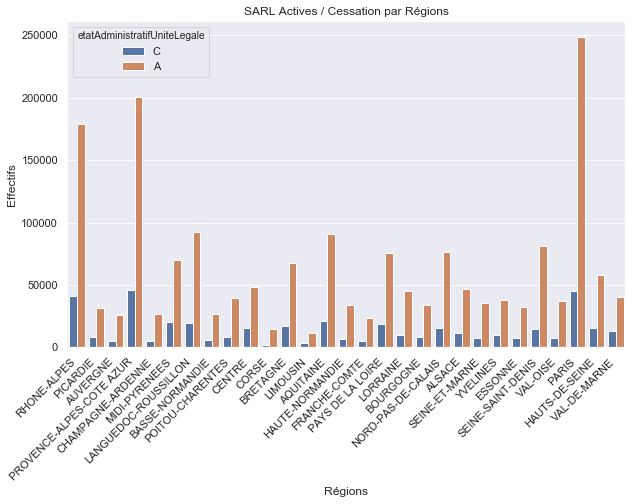

In [48]:
plt.figure(figsize=(10,6))
chart = sns.countplot(x = 'REGIONS', hue = 'etatAdministratifUniteLegale', data = data)
plt.xlabel("Régions")
plt.ylabel("Effectifs")
plt.title("SARL Actives / Cessation par Régions")
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')

Text(0.5, 1.0, 'Matrice de répartition des SARL actives par secteur NAF et par Régions')

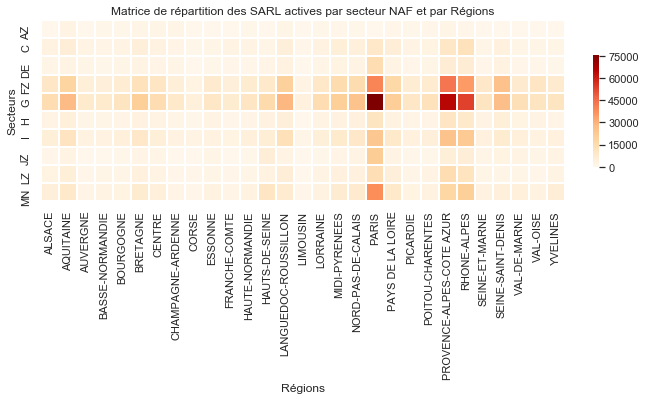

In [71]:
# HeatMap Régions / Secteur Activité

data_a = data[data['etatAdministratifUniteLegale']=='A']

by_sector = (data_a
            .groupby('SECTION_NAF')
            .filter(lambda x : len(x) > 500)
            .groupby(['SECTION_NAF', 'REGIONS'])
            .size()
            .unstack()
           )

plt.figure(figsize=(10,10))

g = sns.heatmap(
    by_sector, 
    square=True,
    cbar_kws={'fraction' : 0.01},
    cmap = 'OrRd',
    linewidth = 1
)

plt.xlabel("Régions")
plt.ylabel("Secteurs")
plt.title('Matrice de répartition des SARL actives par secteur NAF et par Régions')

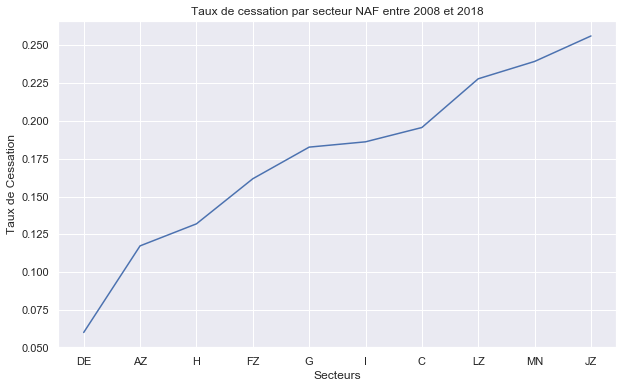

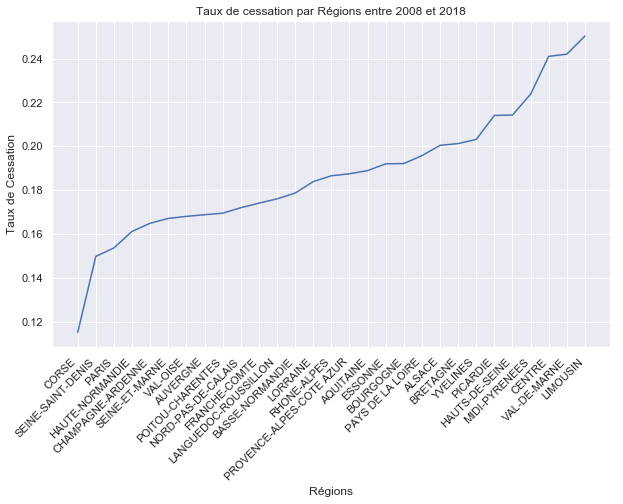

In [68]:
# Taux de cessation par régions / activité
cess = pd.crosstab(data.SECTION_NAF, data.etatAdministratifUniteLegale, normalize = 'index')
cess = pd.DataFrame(cess['C']).sort_values(['C'] , ascending = True)

plt.figure(figsize=(10,6))
plt.plot(cess.index, cess['C'])
plt.xlabel('Secteurs')
plt.ylabel('Taux de Cessation')
plt.title('Taux de cessation par secteur NAF entre 2008 et 2018')
plt.show()

cess = pd.crosstab(data.REGIONS, data.etatAdministratifUniteLegale, normalize = 'index')
cess = pd.DataFrame(cess['C']).sort_values(['C'] , ascending = True)

plt.figure(figsize=(10,6))
plt.plot(cess.index, cess['C'])
plt.xlabel('Régions')
plt.ylabel('Taux de Cessation')
plt.title('Taux de cessation par Régions entre 2008 et 2018')
plt.xticks(rotation = 45, horizontalalignment='right')
#graph.set_xticklabels(graph.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

In [ ]:
sarl_balanced.index = sarl_balanced['KEYJ']

In [ ]:
#pd.isnull(sarl_balanced).sum()

Analyse descriptive

In [ ]:
sarl_balanced.groupby(['SECTION_NAF', 'etatAdministratifUniteLegale'])['N0_AF'].describe()

In [ ]:
# Liste feature
liste = ('N0_AF','N0_BE','N0_BV','N0_CB', 
        'N0_CE','N0_CI','N0_CL','N0_CP','N0_DE','N0_FO', 
        'N0_IN','N0_IR','N0_NC','N0_PK','N0_PP','N0_PT', 
        'N0_RF','N0_RN','N0_RB','N0_RP','N0_ST','N0_TM',
        'VarN0_AE','VarN0_AF','VarN0_BE','VarN0_BV','VarN0_CB', 
        'VarN0_CE','VarN0_CI','VarN0_CL','VarN0_CP','VarN0_DE','VarN0_FO', 
        'VarN0_IN','VarN0_IR','VarN0_NC','VarN0_PK','VarN0_PP','VarN0_PT', 
        'VarN0_ST','VarN0_TM','VarN0_RN','VarN0_RB','VarN0_RP','VAR_DEFAILLANCE',
        'anc_der_chg_cat_ju','anc_der_chg_act','anc_der_chg_den','nb_etablissement_ferme',
        'anc_der_chg_emp','anc_der_chg_ess','age_unite_legale')

output = sarl_balanced.groupby(['etatAdministratifUniteLegale'])['N0_AE'].describe()
output['Feature'] = 'N0_AE'

# Analyse descriptive des variables
for feature in liste:
    describe = sarl_balanced.groupby(['etatAdministratifUniteLegale'])[feature].describe()
    describe['Feature'] = feature
    output = pd.concat([output, describe], axis=0)
    
output.to_csv('C:/Users/Square 769/Documents/SIRENE/072019/DESCRIPTIVE_update.csv', encoding = 'utf-8')

In [ ]:
liste = ('Mod_AE','Mod_AF','Mod_BE','Mod_BV','Mod_CB', 
        'Mod_CE','Mod_CI','Mod_CL','Mod_DE','Mod_FO', 
        'Mod_IR','Mod_NC','Mod_PK','Mod_PP','Mod_PT', 
        'Mod_RF','Mod_RN','Mod_RB', 'Mod_RP')

liste = ('Mod_RP','SECTION_NAF')

for j in liste:
    print(pd.crosstab(sarl_balanced.etatAdministratifUniteLegale, sarl_balanced[j], normalize = 'columns'))

In [ ]:
sarl_balanced['N0_RF'].describe()

In [ ]:
import numpy as np
test_den = pd.cut(sarl_balanced.nb_etablissement_ferme, [-1000,1,1000], labels = ['1','2'])
test_den = np.where(test_den.isna(),'missing',test_den)

print(pd.crosstab(sarl_balanced.etatAdministratifUniteLegale, test_den, normalize = 'columns'))
print(pd.crosstab(sarl_balanced.etatAdministratifUniteLegale, test_den))

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix as cm

In [ ]:
# Calcul du V de Cramer
import numpy as np
import scipy.stats as ss

def cramers_corrected_stat(x,y):

    result=-1
 
    conf_matrix=pd.crosstab(x, y)

    if conf_matrix.shape[0]==2:
        correct=False
    else:
        correct=True

    chi2 = ss.chi2_contingency(conf_matrix, correction=correct)[0]

    n = sum(conf_matrix.sum())
    phi2 = chi2/n
    r,k = conf_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    result=np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
    
    return round(result, 4)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
sns.set()
sns.countplot(x = 'Mod_AE', data = sarl_balanced)
plt.xlabel('Variable Mod_AE')
plt.ylabel('Fréquence')
plt.legend()

In [ ]:
#Liste decoupage binaire
liste = ('N0_AF','N0_BE','N0_BV','N0_CB','N0_DE','N0_IN','N0_IR',
         'N0_NC','N0_PK','N0_PP','N0_PT','N0_RF','N0_RP','N0_ST',
         'N0_TM','VarN0_AE','VarN0_AF','VarN0_BV','VarN0_CE','VarN0_CI',
         'VarN0_CP','VarN0_IR','VarN0_PK','VarN0_ST','VarN0_TM','VarN0_RN',
         'VarN0_RB','VAR_DEFAILLANCE')

In [ ]:
from sklearn import preprocessing
data = sarl_balanced[['etatAdministratifUniteLegale','SECTION_NAF']].reset_index()
le = preprocessing.LabelEncoder()
le.fit(data['SECTION_NAF'])
le.transform(data['SECTION_NAF'])

In [ ]:
# Liste découpagne multiclasse
liste = ('anc_der_chg_cat_ju','anc_der_chg_act','anc_der_chg_den',
        'anc_der_chg_emp','age_unite_legale')

In [ ]:
# Liste découpage multiclasse
liste = ('VAR_DEFAILLANCE','nb_etablissement_ferme')

In [ ]:
# Macro de découpage par arbre de décision - non optimisée
# Paramètre variable h = profondeur

h = 1

Cramer = []
ListF = []
Poids1 = []
Poids2 = []
#Poids3 = []
#Poids4 = []
Seuil1 = []
Seuil2 = []
#Seuil3 = []
#Seuil4 = []
tc1 = []
tc2 = []
#tc3 = []
#tc4 = []

for feature in liste:

    data = sarl_balanced[['etatAdministratifUniteLegale',feature]].reset_index()
    print("--> Avant exclusion")
    print(data[feature].count())
    data = data.dropna(axis = 0)
    print("--> Apres exclusion")
    print(data[feature].count())
    data.drop('KEYJ', axis = 1, inplace = True)
    data = data.join(pd.get_dummies(data.etatAdministratifUniteLegale, prefix = "CESSATION"))
    data.drop('CESSATION_A', axis = 1, inplace = True)

    X = data[[feature,'CESSATION_C']]
    Y = data.CESSATION_C

    from sklearn.tree import DecisionTreeClassifier
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 123)
    tree = DecisionTreeClassifier(criterion = "entropy", max_depth = h)
    tree.fit(x_train[feature].to_frame(), y_train)

    x_train[feature+'_tree'] = tree.predict_proba(x_train[feature].to_frame())[:,1]

    print('#################################################')
    print('### Segmentation de la variable '+feature+'   ###')
    print('### pour decision tree max depth = '+str(h)+' ###')
    print('#################################################')

    pred = tree.predict(x_test[feature].to_frame())
    
    print(cm(pred,y_test))
    
    cf = pd.crosstab(x_train[feature+'_tree'], y_train)
    
    print(cf)
    print('#################################################')
    print(cramers_corrected_stat(x_train[feature+'_tree'],y_train))
    
    ListF.append(feature)
    Cramer.append(cramers_corrected_stat(x_train[feature+'_tree'],y_train))

    x_train.groupby([feature+'_tree'])['CESSATION_C'].count().plot.bar()
    plt.show()
    
    rep = x_train.groupby([feature+'_tree'])['CESSATION_C'].count()
    pct1 = rep.iloc[0] / x_train['CESSATION_C'].count()
    pct2 = rep.iloc[1] / x_train['CESSATION_C'].count()
    #pct3 = rep.iloc[2] / x_train['CESSATION_C'].count()
    #pct4 = rep.iloc[3] / x_train['CESSATION_C'].count()
    
    Poids1.append(pct1)
    Poids2.append(pct2)
    #Poids3.append(pct3)
    #Poids4.append(pct4)
    
    t1 = x_train.groupby(x_train[feature+'_tree'])[feature+'_tree'].mean().iloc[0]
    t2 = x_train.groupby(x_train[feature+'_tree'])[feature+'_tree'].mean().iloc[1]
    #t3 = x_train.groupby(x_train[feature+'_tree'])[feature+'_tree'].mean().iloc[2]
    #t4 = x_train.groupby(x_train[feature+'_tree'])[feature+'_tree'].mean().iloc[3]
    
    tc1.append(t1)
    tc2.append(t2)
    #tc3.append(t3)
    #tc4.append(t4)
    
    print(pd.concat([x_train.groupby([feature+'_tree'])[feature].min(), x_train.groupby([feature+'_tree'])[feature].max()], axis = 1))
    
    decoup = pd.concat([x_train.groupby([feature+'_tree'])[feature].min(), x_train.groupby([feature+'_tree'])[feature].max()], axis = 1)
    Seuil1.append(decoup.iloc[0,1])
    Seuil2.append(decoup.iloc[1,1])
    #Seuil3.append(decoup.iloc[2,1])
    #Seuil4.append(decoup.iloc[3,1])

In [ ]:
# Extraction binaire
df1 = pd.DataFrame(ListF, columns=['Feature'])
df2 = pd.DataFrame(Cramer, columns=['V Cramer'])
df3 = pd.DataFrame(Poids1, columns=['Poids modalité 1'])
df4 = pd.DataFrame(Poids2, columns=['Poids modalité 2'])
df7 = pd.DataFrame(Seuil1, columns=['Seuil modalité 1'])
df8 = pd.DataFrame(Seuil2, columns=['Seuil modalité 2'])
df9 = pd.DataFrame(tc1, columns=['Taux cessation groupe 1'])
df10 = pd.DataFrame(tc2, columns=['Taux cessation groupe 2'])

output = pd.concat([df1,df2,df3,df4,df7,df8,df9,df10], axis=1)
output.to_csv('C:/Users/Square 769/Documents/SIRENE/072019/RAPPORT_DECOUPAGE_1.csv', encoding = 'utf-8')

In [ ]:
# Extraction lorsque h > 1
df1 = pd.DataFrame(ListF, columns=['Feature'])
df2 = pd.DataFrame(Cramer, columns=['V Cramer'])
df3 = pd.DataFrame(Poids1, columns=['Poids modalité 1'])
df4 = pd.DataFrame(Poids2, columns=['Poids modalité 2'])
df5 = pd.DataFrame(Poids3, columns=['Poids modalité 3'])
df6 = pd.DataFrame(Poids4, columns=['Poids modalité 4'])
df7 = pd.DataFrame(Seuil1, columns=['Seuil modalité 1'])
df8 = pd.DataFrame(Seuil2, columns=['Seuil modalité 2'])
df9 = pd.DataFrame(Seuil3, columns=['Seuil modalité 3'])
df10 = pd.DataFrame(Seuil4, columns=['Seuil modalité 4'])
df11 = pd.DataFrame(tc1, columns=['Taux cessation groupe 1'])
df12 = pd.DataFrame(tc2, columns=['Taux cessation groupe 2'])
df13 = pd.DataFrame(tc3, columns=['Taux cessation groupe 3'])
df14 = pd.DataFrame(tc4, columns=['Taux cessation groupe 4'])

output = pd.concat([df1,df2,df3,df4,df5,df6,df7,df8,df9,df10,df11,df12,df13,df14], axis=1)

output.to_csv('C:/Users/Square 769/Documents/SIRENE/072019/RAPPORT_DECOUPAGE_2.csv', encoding = 'utf-8')